# Customer churn prediction

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score,fbeta_score 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
# from roc_curve import plot_roc
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import random

import matplotlib.pyplot as plt
%matplotlib inline

### import data

In [2]:
test = pd.read_csv('data/churn_test.csv',parse_dates=['last_trip_date','signup_date'])
train = pd.read_csv('data/churn_train.csv', parse_dates=['last_trip_date','signup_date'])

In [3]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null datetime64[ns]
phone                     39681 non-null object
signup_date               40000 non-null datetime64[ns]
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.4+ MB


In [4]:
train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


### feature engineering

In [5]:
today=pd.to_datetime('2014-07-01')
churn_date=pd.to_datetime('2014-06-01')
train['churn'] = churn_date > train['last_trip_date']
train.head(20)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0,True
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0,True
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0,True
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0,True
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0,True
5,14.51,5.0,NaN,1.00,Astapor,2014-04-22,iPhone,2014-01-29,0.0,0,True,100.0,True
6,4.87,4.7,4.0,1.00,Astapor,2014-04-21,Android,2014-01-18,0.0,0,False,66.7,True
7,1.78,4.0,5.0,1.00,Winterfell,2014-01-12,iPhone,2014-01-11,0.0,3,False,0.0,True
8,6.87,5.0,4.7,1.00,Astapor,2014-01-30,Android,2014-01-01,0.0,3,False,66.7,True
9,2.41,5.0,3.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,1,False,100.0,True


In [6]:
train['churn'].value_counts()

True     24968
False    15032
Name: churn, dtype: int64

In [7]:
train['churn'][train['churn']==True].value_counts()/train['churn'].count()

True    0.6242
Name: churn, dtype: float64

In [8]:
train['signup_date']= pd.to_datetime(train['signup_date'])
train['account_length']= today - train['signup_date'] #=>xxx days
train['account_length']=train['account_length'].dt.days # =>xxx
train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,account_length
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0,True,170
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0,True,157
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0,True,180
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0,True,173
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0,True,151


### deal with missing data: phone, average rating by driver, average rating of driver

In [9]:
train['phone'].value_counts()

iPhone     27628
Android    12053
Name: phone, dtype: int64

In [10]:
phone=pd.get_dummies(train['phone'])
luxuary=pd.get_dummies(train['luxury_car_user'],prefix='luxuary_')
train=train.join(phone).join(luxuary)
train.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,account_length,Android,iPhone,luxuary__False,luxuary__True
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0,True,170,1,0,1,0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0,True,157,1,0,0,1
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0,True,180,0,1,0,1
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0,True,173,1,0,1,0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0,True,151,0,1,1,0


In [11]:
mean_rating_by_driver=train['avg_rating_by_driver'].mean()
train['avg_rating_by_driver']=train['avg_rating_by_driver'].fillna(mean_rating_by_driver)

mean_rating_of_driver=train['avg_rating_of_driver'].mean()
train['avg_rating_of_driver']=train['avg_rating_of_driver'].fillna(mean_rating_of_driver)

# train[train['avg_rating_by_driver'].isnull()==True]

In [12]:
train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,account_length,Android,iPhone,luxuary__False,luxuary__True
0,6.94,5.0,5.000000,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0,True,170,1,0,1,0
1,8.06,5.0,5.000000,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0,True,157,1,0,0,1
2,21.50,4.0,4.601697,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0,True,180,0,1,0,1
3,9.46,5.0,4.601697,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0,True,173,1,0,1,0
4,13.77,5.0,4.601697,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0,True,151,0,1,1,0


### deal with categorical data

In [13]:
train=train.drop(['phone','luxury_car_user','signup_date'],axis=1)

In [14]:
# today = pd.to_datetime('2014-07-01')
# churn_date = pd.to_datetime('2014-06-01')
# df['account_length_days'] = today - df.signup_date
# df['account_length_days'] = df['account_length_days'].dt.days
# df['Churned'] = df.last_trip_date < churn_date
# df = pd.get_dummies(df, columns=['city', 'phone'])
# df['avg_rating_of_driver_wasNULL'] = df['avg_rating_of_driver'].isnull()
# mean_avg_driver_rating = df['avg_rating_of_driver'].mean()
# df['avg_rating_of_driver_noNULL'] = df['avg_rating_of_driver'].fillna(mean_avg_driver_rating)
# df['avg_rating_by_driver_wasNULL'] = df['avg_rating_by_driver'].isnull()
# mean_avg_by_driver_rating = df['avg_rating_by_driver'].mean()
# df['avg_rating_by_driver_noNULL'] = df['avg_rating_by_driver'].fillna(mean_avg_by_driver_rating)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      40000 non-null float64
avg_rating_of_driver      40000 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null datetime64[ns]
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
weekday_pct               40000 non-null float64
churn                     40000 non-null bool
account_length            40000 non-null int64
Android                   40000 non-null uint8
iPhone                    40000 non-null uint8
luxuary__False            40000 non-null uint8
luxuary__True             40000 non-null uint8
dtypes: bool(1), datetime64[ns](1), float64(6), int64(2), object(1), uint8(4)
memory usage: 3.2+ MB


In [16]:
train['city'].value_counts()

Winterfell        18620
Astapor           13236
King's Landing     8144
Name: city, dtype: int64

In [17]:
city=pd.get_dummies(train['city'],prefix='city_')
print city.head()
train.join(city)
train=train.drop(['city'],axis=1)
train.head()

   city__Astapor  city__King's Landing  city__Winterfell
0              1                     0                 0
1              1                     0                 0
2              0                     0                 1
3              0                     0                 1
4              0                     0                 1


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,trips_in_first_30_days,weekday_pct,churn,account_length,Android,iPhone,luxuary__False,luxuary__True
0,6.94,5.0,5.000000,1.00,2014-05-03,0.0,0,100.0,True,170,1,0,1,0
1,8.06,5.0,5.000000,1.00,2014-01-26,0.0,2,0.0,True,157,1,0,0,1
2,21.50,4.0,4.601697,1.00,2014-05-21,0.0,1,100.0,True,180,0,1,0,1
3,9.46,5.0,4.601697,2.75,2014-01-10,100.0,1,100.0,True,173,1,0,1,0
4,13.77,5.0,4.601697,1.00,2014-05-13,0.0,0,100.0,True,151,0,1,1,0


In [18]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,40000.0,5.791302,5.708056,0.0,2.42,3.88,6.93,160.96
avg_rating_by_driver,40000.0,4.777434,0.447180,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,40000.0,4.601697,0.562407,1.0,4.50,4.70,5.00,5.00
avg_surge,40000.0,1.074956,0.222427,1.0,1.00,1.00,1.05,8.00
surge_pct,40000.0,8.857342,20.014008,0.0,0.00,0.00,8.30,100.00
trips_in_first_30_days,40000.0,2.280700,3.811289,0.0,0.00,1.00,3.00,125.00
weekday_pct,40000.0,60.874382,37.089619,0.0,33.30,66.70,100.00,100.00
account_length,40000.0,165.460500,8.749512,151.0,158.00,165.00,173.00,181.00
Android,40000.0,0.301325,0.458839,0.0,0.00,0.00,1.00,1.00
iPhone,40000.0,0.690700,0.462211,0.0,0.00,1.00,1.00,1.00


In [19]:
train.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn,account_length,Android,iPhone,luxuary__False,luxuary__True
avg_dist,1.000000,0.081380,0.030450,-0.079488,-0.102349,-0.135228,0.097445,0.093371,-0.017206,0.019800,-0.023702,-0.025824,0.025824
avg_rating_by_driver,0.081380,1.000000,0.097762,0.007777,0.018709,-0.039264,0.021471,0.027415,-0.000756,0.004643,-0.005777,-0.010283,0.010283
avg_rating_of_driver,0.030450,0.097762,1.000000,-0.027851,-0.008782,-0.013426,0.011373,0.011982,-0.007156,0.027814,-0.028006,-0.001615,0.001615
avg_surge,-0.079488,0.007777,-0.027851,1.000000,0.793842,-0.001829,-0.113054,0.003146,0.008795,-0.009684,0.011530,0.075544,-0.075544
surge_pct,-0.102349,0.018709,-0.008782,0.793842,1.000000,0.004746,-0.147969,-0.011551,0.001564,-0.011386,0.013835,0.103531,-0.103531
trips_in_first_30_days,-0.135228,-0.039264,-0.013426,-0.001829,0.004746,1.000000,0.049731,-0.210677,-0.014482,-0.057818,0.056907,-0.114741,0.114741
weekday_pct,0.097445,0.021471,0.011373,-0.113054,-0.147969,0.049731,1.000000,-0.008383,-0.003588,-0.008750,0.005988,-0.033478,0.033478
churn,0.093371,0.027415,0.011982,0.003146,-0.011551,-0.210677,-0.008383,1.000000,-0.019143,0.226292,-0.227084,0.206902,-0.206902
account_length,-0.017206,-0.000756,-0.007156,0.008795,0.001564,-0.014482,-0.003588,-0.019143,1.000000,-0.015042,0.015902,-0.004261,0.004261
Android,0.019800,0.004643,0.027814,-0.009684,-0.011386,-0.057818,-0.008750,0.226292,-0.015042,1.000000,-0.981374,0.073530,-0.073530


### EDA


In [20]:
train['last_trip_date'].dt.month.value_counts()

6    14595
1     8172
5     6088
4     3658
3     3626
2     3424
7      437
Name: last_trip_date, dtype: int64

In [21]:
June_trips=train['last_trip_date'][train['last_trip_date'].dt.month==6].dt.day.value_counts().to_frame().sort_index()

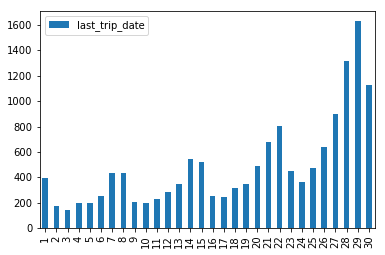

In [22]:
June_trips.plot(kind='bar')

In [23]:
train.columns.tolist()

['avg_dist',
 'avg_rating_by_driver',
 'avg_rating_of_driver',
 'avg_surge',
 'last_trip_date',
 'surge_pct',
 'trips_in_first_30_days',
 'weekday_pct',
 'churn',
 'account_length',
 'Android',
 'iPhone',
 'luxuary__False',
 'luxuary__True']

In [24]:
features=train.drop(['churn','last_trip_date',],axis=1)
X=features
target=train['churn']
y=target
X_train, X_validate, y_train, y_validate=train_test_split(X, y,test_size=0.25)


In [25]:
X.columns.tolist()

['avg_dist',
 'avg_rating_by_driver',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'trips_in_first_30_days',
 'weekday_pct',
 'account_length',
 'Android',
 'iPhone',
 'luxuary__False',
 'luxuary__True']

## ROC curve

In [26]:
# def roc_curve(probabilities, labels):
    

## Random Forest

### find the optimal number of features and trees

[0.72272000000000003, 0.72438000000000002, 0.72306000000000004, 0.72451999999999994, 0.72577999999999998, 0.72662000000000004, 0.72222000000000008, 0.72245999999999999, 0.71821999999999997, 0.7196999999999999, 0.71820000000000006, 0.71660000000000001]


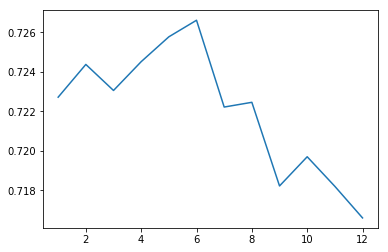

In [27]:
#Try modifying the number of features
num_features = range(1, len(list(features.columns))+1)
# print num_features
accuracies = []

for n in num_features:
    total = 0
    for i in xrange(5): # with same n features, random pick n features for 5 times and take average 
        clf_rf = RandomForestClassifier(max_features=n, n_jobs = -1)
        clf_rf.fit(X_train, y_train)
        total += clf_rf.score(X_validate, y_validate)  
    accuracies.append(total / 5)
print accuracies
plt.plot(num_features, accuracies)
plt.show()
# best num of features is 4

[0.67627999999999999, 0.72967999999999988, 0.73712, 0.74030000000000007, 0.74363999999999997, 0.74268000000000001, 0.74269999999999992, 0.74312, 0.74408000000000007, 0.74502000000000002, 0.74587999999999999, 0.74624000000000001, 0.74694000000000005, 0.74676000000000009, 0.74673999999999996, 0.74658000000000002, 0.74614000000000003, 0.74625999999999992, 0.7464599999999999, 0.74746000000000001]


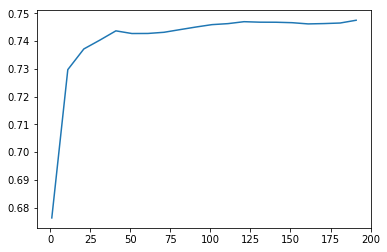

In [28]:
#Try modifying the number of trees
num_trees = range(1,200,10)
accuracies = []
for n in num_trees:
    total = 0
    for i in xrange(5):
        clf_rf = RandomForestClassifier(n_estimators=n,n_jobs = -1)
        clf_rf.fit(X_train, y_train)
        total += clf_rf.score(X_validate, y_validate)
    accuracies.append(total / 5)
print accuracies
plt.plot(num_trees, accuracies)
plt.show()
# best num of trees is 75 

#### apply model

In [29]:
clf_rf=RandomForestClassifier(n_estimators=125,oob_score=True,max_features=4)
clf_rf.fit(X_train,y_train)
print "training score:", clf_rf.score(X_train,y_train)
print "accuracy score:", clf_rf.score(X_validate,y_validate)

training score: 0.9998
accuracy score: 0.7444


In [30]:
clf_rf=RandomForestClassifier(n_estimators=125,oob_score=True,max_features='auto')
clf_rf.fit(X_train,y_train)
print "training score:", clf_rf.score(X_train,y_train)
print "accuracy score:", clf_rf.score(X_validate,y_validate)

training score: 0.9998
accuracy score: 0.7439


In [31]:
clf_rf=RandomForestClassifier(n_estimators=125,max_features=4) 
clf_rf.fit(X_train,y_train)
print "training score:", clf_rf.score(X_train,y_train)
print "accuracy score:", clf_rf.score(X_validate,y_validate)

training score: 0.999766666667
accuracy score: 0.7448


In [32]:
clf_rf=RandomForestClassifier(n_estimators=125,max_features='auto') 
clf_rf.fit(X_train,y_train)
print "training score:", clf_rf.score(X_train,y_train)
print "accuracy score:", clf_rf.score(X_validate,y_validate)

training score: 0.9998
accuracy score: 0.7457


In [33]:
y_predict = clf_rf.predict(X_validate)
print "confusion matrix:"
print confusion_matrix(y_validate, y_predict)

confusion matrix:
[[2311 1414]
 [1129 5146]]


In [35]:
# n=10
# # importances = forest_fit.feature_importances_[:n]
# importances = clf_rf.feature_importances_[:n]
# std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]
# features = list(df.columns[indices])

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(n):
#     print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

In [ ]:
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
# plt.xticks(range(10), indices)
# plt.xlim([-1, 10])
# plt.savefig('13_Feature_ranking.png')
# plt.close()
# print('\nPlotted 13) feature importances')

In [36]:
print "precision:", precision_score(y_validate, y_predict)
print "recall:", recall_score(y_validate, y_predict)
print ""
print 'f1 macro', f1_score(y_validate, y_predict, average='macro') 
print 'f1 micro', f1_score(y_validate, y_predict, average='micro') 
print 'f1 weighted',f1_score(y_validate, y_predict, average='weighted') 
print ""
print 'fbeta', fbeta_score(y_validate, y_predict, average='macro', beta=2)
print 'fbeta', fbeta_score(y_validate, y_predict, average='micro', beta=2)
print 'fbeta', fbeta_score(y_validate, y_predict, average='weighted', beta=2)

precision: 0.784451219512
recall: 0.820079681275

f1 macro 0.723475069124
f1 micro 0.7457
f1 weighted 0.74346574769

fbeta 0.721370515241
fbeta 0.7457
fbeta 0.7446588734


In [40]:
def k_fold_cross_val(cleaned_X, cleaned_y, k = 5, metric = fbeta_score, beta = 2, model_class = None, **model_params):
    '''
    ** make sure you've imported KFold from sklearn.model_selection and pandas (pd) and numpy (np)
    inputs: k = number of splits for k fold validation
            cleaned_X = 2D pandas df
            cleaned_y = 1D pandas df
            metric = what we're scoring on, needs to take y_true and y_predicted
            model_class = what model we're using, make sure it has fit and predict methods
            model_params = optional args to feed into the model, ie max_depth, alpha, etc
    
    output: the average score from metric across the folds
    
    '''
    kf = KFold(n_splits = k)
    scores = []
    for train_index, test_index in kf.split(cleaned_X):
        X_train, X_test = cleaned_X.values[train_index], cleaned_X.values[test_index]
        y_train, y_test = cleaned_y.values[train_index], cleaned_y.values[test_index]
        model = model_class(**model_params)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        if metric == fbeta_score:
            fold_score = metric(y_test, y_predict, beta)
        else:
            fold_score = metric(y_test, y_predict)
        scores.append(fold_score)
    return np.mean(scores)


In [41]:
cleaned_X=features
cleaned_y=target

k_fold_cross_val(cleaned_X, cleaned_y, k = 5, metric = fbeta_score, beta = 1, model_class = RandomForestClassifier, n_estimators=150)

0.79816711093976722

In [42]:
k_fold_cross_val(cleaned_X, cleaned_y, k = 5, metric = fbeta_score, beta = 2, model_class = RandomForestClassifier, n_estimators=150)

0.80997817886038048

In [43]:
k_fold_cross_val(cleaned_X, cleaned_y, k = 5, metric = precision_score, model_class = RandomForestClassifier, n_estimators=150)

0.77964833716547299

In [44]:
k_fold_cross_val(cleaned_X, cleaned_y, k = 5, metric = recall_score, model_class = RandomForestClassifier, n_estimators=150)

0.81842121520234823

In [45]:
#plot feature importance 
def plot_forest_importances(model, X):
    n_features = X.shape[1]
    colnames = X.columns.values   
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n_features), importances[indices],
           color="r", yerr=std[indices], tick_label = colnames[indices], align="center")
    #plt.xticks(range(n_features), indices)
    plt.xlim([-1, n_features])
    plt.xticks(range(n_features), colnames, rotation='vertical')
    plt.show()
    pass

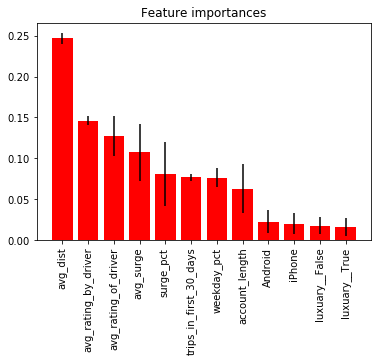

In [46]:
X=features
model=clf_rf
plot_forest_importances(model, X)

In [47]:
fpr,tpr,thresholds=roc_curve(y_validate, y_predict)
roc_auc=auc(fpr,tpr)

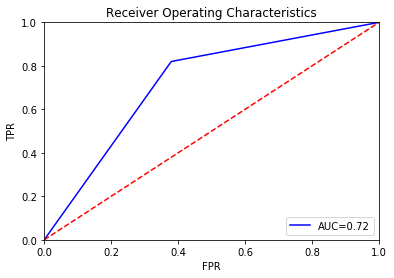

In [48]:
plt.title('Receiver Operating Characteristics')
plt.plot(fpr,tpr,'b',label='AUC=%.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()